# CIFAR-100 Inference with v28 Trained Model

This notebook demonstrates how to load a trained v28 CUDA Fortran model and use it for inference.

**Features:**
- Load exported model weights
- Make predictions on test images
- Visualize predictions with confidence scores
- Generate confusion matrix
- Analyze misclassified examples
- Per-class accuracy analysis

---

## Setup

Import required libraries and set up visualization settings.

In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from pathlib import Path
import importlib

# Import model loader from inference directory
sys.path.append('../../inference')
import model_loader
importlib.reload(model_loader)  # Force reload to get latest changes
from model_loader import load_v28_model, load_metadata

# Set up matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060


## 1. Load Trained Model

Load the v28 trained model from exported binary files.

In [2]:
# Model directory
MODEL_DIR = './saved_models/cifar100/'

# Load model
print("Loading v28 CIFAR-100 model...")
print("=" * 70)
model = load_v28_model(MODEL_DIR,
                       in_channels=3,      # RGB
                       num_classes=100,    # 100 object categories
                       input_size=32,      # 32x32 images
                       device=device)

# Load metadata
metadata = load_metadata(MODEL_DIR)
if metadata:
    print("\nModel Metadata:")
    print(f"  Dataset: {metadata.get('dataset', 'N/A')}")
    print(f"  Training Accuracy: {metadata.get('accuracy', 'N/A')}%")
    print(f"  Epochs: {metadata.get('epochs', 'N/A')}")
    print(f"  Export Date: {metadata.get('export_date', 'N/A')}")

print("\n✅ Model loaded successfully!")

Loading v28 CIFAR-100 model...
Loading v28 model from: saved_models/cifar100
Auto-detected flatten_size: 2048
Loading Conv Layers...
Loaded Conv1 (Dynamic Shape: (3, 3, 3, 32))
Loaded Conv2 (Dynamic Shape: (3, 3, 32, 64))
Loaded Conv3 (Dynamic Shape: (3, 3, 64, 128))
Loading FC1...
Loading FC2...
Loading FC3...
Loading BatchNorm layers...
✅ Model loaded successfully!
   Device: cuda
   Architecture: 3ch → Conv32 → Conv64 → Conv128 → FC512 → FC256 → FC100

Model Metadata:
  Dataset: CIFAR-100
  Training Accuracy: 46.74%
  Epochs: 15
  Export Date: 2025-11-17

✅ Model loaded successfully!


## 2. Load Test Dataset

Load the CIFAR-100 T test dataset.

In [3]:
# CIFAR-100 class names (100 fine-grained categories)
CLASS_NAMES = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
    'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank',
    'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip',
    'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# Load test dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0, 1]
])

test_dataset = datasets.CIFAR100(root='./data', train=False,
                                 download=True, transform=transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                          shuffle=False, num_workers=2)

print(f"Test dataset: {len(test_dataset)} images")
print(f"Classes: {len(CLASS_NAMES)} categories")

Test dataset: 10000 images
Classes: 100 categories


## 3. Single Image Prediction

Let's make a prediction on a single test image.

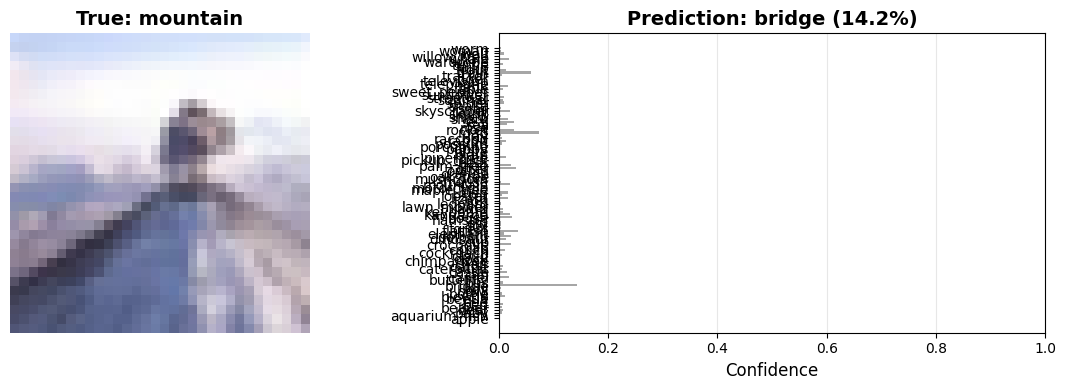


True Label: mountain
Prediction: bridge
Confidence: 14.24%
Correct: False


In [4]:
# Get a sample image
sample_idx = 0  # Try different indices: 0, 10, 100, etc.
image, true_label = test_dataset[sample_idx]

# Make prediction
model.eval()
with torch.no_grad():
    image_batch = image.unsqueeze(0).to(device)  # Add batch dimension
    output = model(image_batch)
    probabilities = torch.softmax(output, dim=1)
    prediction = torch.argmax(output, dim=1).item()
    confidence = probabilities[0, prediction].item()

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Show image (RGB)
ax1.imshow(image.permute(1, 2, 0))  # CHW -> HWC for display
ax1.axis('off')
ax1.set_title(f'True: {CLASS_NAMES[true_label]}', fontsize=14, fontweight='bold')

# Show prediction probabilities
probs = probabilities[0].cpu().numpy()
colors = ['green' if i == prediction else 'gray' for i in range(10)]
ax2.barh(CLASS_NAMES, probs, color=colors, alpha=0.7)
ax2.set_xlabel('Confidence', fontsize=12)
ax2.set_title(f'Prediction: {CLASS_NAMES[prediction]} ({confidence:.1%})', 
              fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1])

# Add grid
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTrue Label: {CLASS_NAMES[true_label]}")
print(f"Prediction: {CLASS_NAMES[prediction]}")
print(f"Confidence: {confidence:.2%}")
print(f"Correct: {prediction == true_label}")

## 4. Batch Evaluation

Evaluate the model on the entire test set.

In [5]:
print("Evaluating on test set...")

model.eval()
correct = 0
total = 0
all_predictions = []
all_labels = []
all_confidences = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        predictions = torch.argmax(outputs, dim=1)
        
        # Store results
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Get confidence for each prediction
        confidences = probabilities[range(len(predictions)), predictions]
        all_confidences.extend(confidences.cpu().numpy())
        
        # Calculate accuracy
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = 100.0 * correct / total

print(f"\n{'='*70}")
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Correct: {correct}/{total}")
print(f"{'='*70}")

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_confidences = np.array(all_confidences)

Evaluating on test set...

Test Accuracy: 46.55%
Correct: 4655/10000


## 5. Confusion Matrix

Visualize which classes are confused with each other.

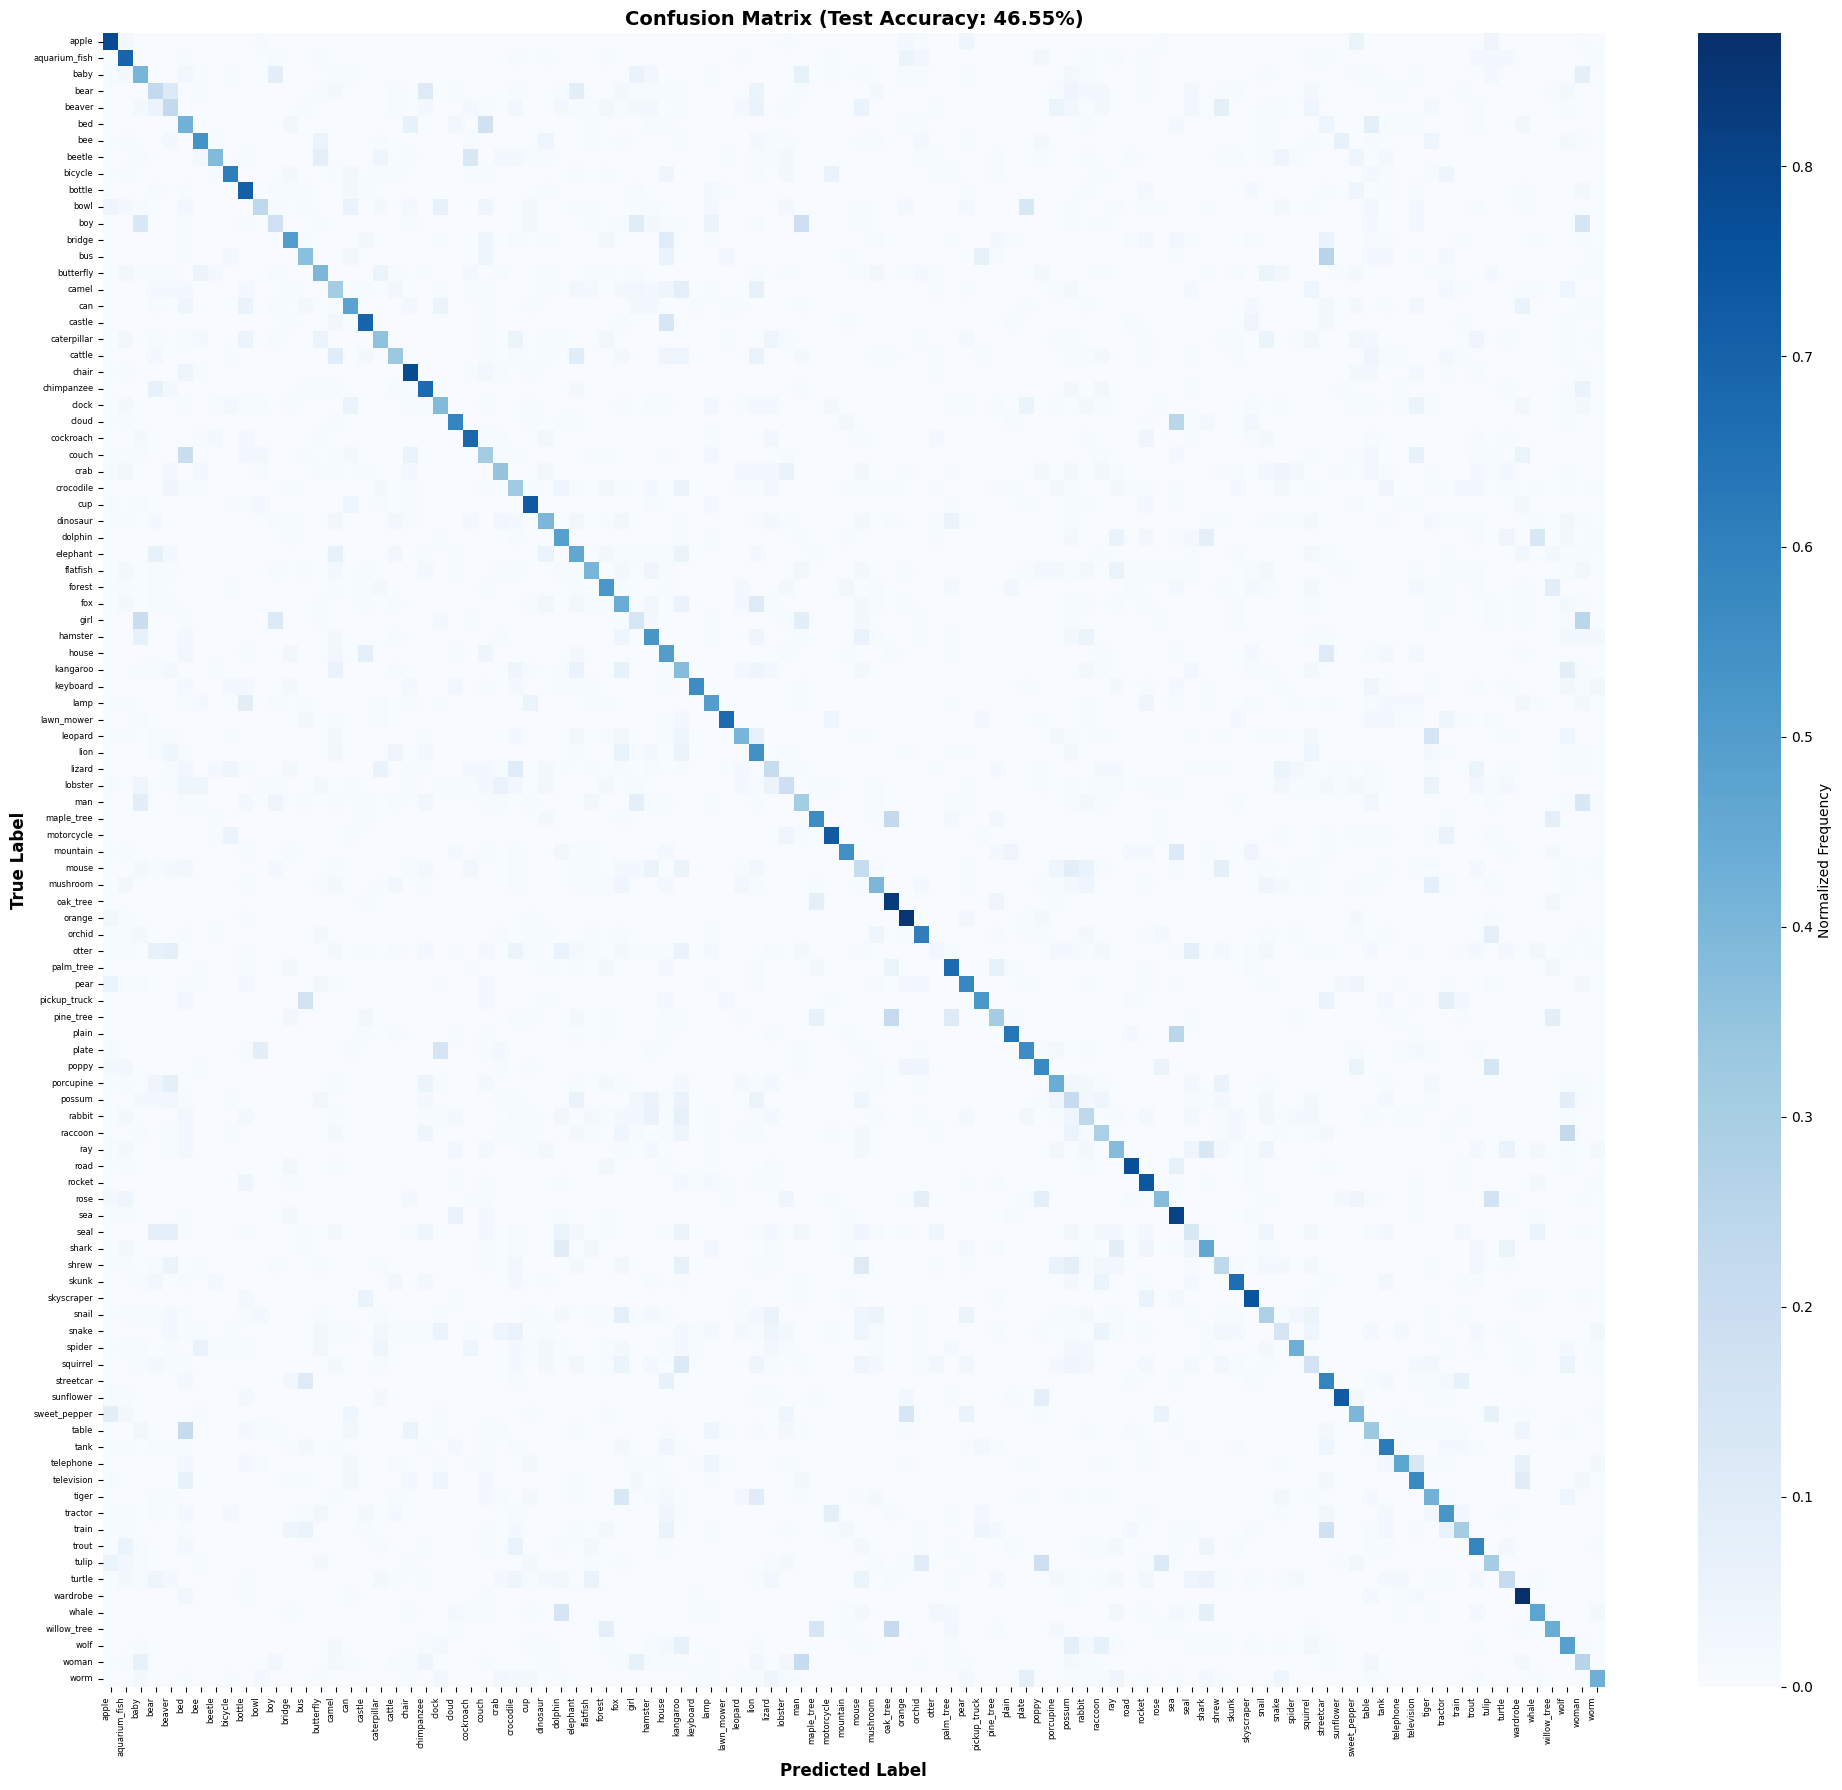


Most Confused Pairs:
  bus                  → streetcar           : 26.0%
  plain                → sea                 : 25.0%
  girl                 → woman               : 25.0%
  cloud                → sea                 : 25.0%
  raccoon              → wolf                : 23.0%
  maple_tree           → oak_tree            : 23.0%
  woman                → man                 : 22.0%
  table                → bed                 : 22.0%
  pine_tree            → oak_tree            : 22.0%
  willow_tree          → oak_tree            : 22.0%


In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Normalize by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot (larger figure for 100 classes)
plt.figure(figsize=(20, 18))
sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Normalized Frequency'})
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix (Test Accuracy: {accuracy:.2f}%)', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=90, ha='right', fontsize=6)
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()
plt.show()

print("\nMost Confused Pairs:")
print("=" * 70)
# Find top confusions (excluding diagonal)
cm_no_diag = cm_normalized.copy()
np.fill_diagonal(cm_no_diag, 0)
top_confusions = np.argsort(cm_no_diag.flatten())[-10:][::-1]

for idx in top_confusions:
    i, j = idx // 100, idx % 100
    if cm_no_diag[i, j] > 0.02:  # Only show significant confusions
        print(f"  {CLASS_NAMES[i]:20s} → {CLASS_NAMES[j]:20s}: {cm_no_diag[i,j]:.1%}")

## 6. Per-Class Accuracy

Analyze accuracy for each fashion category.

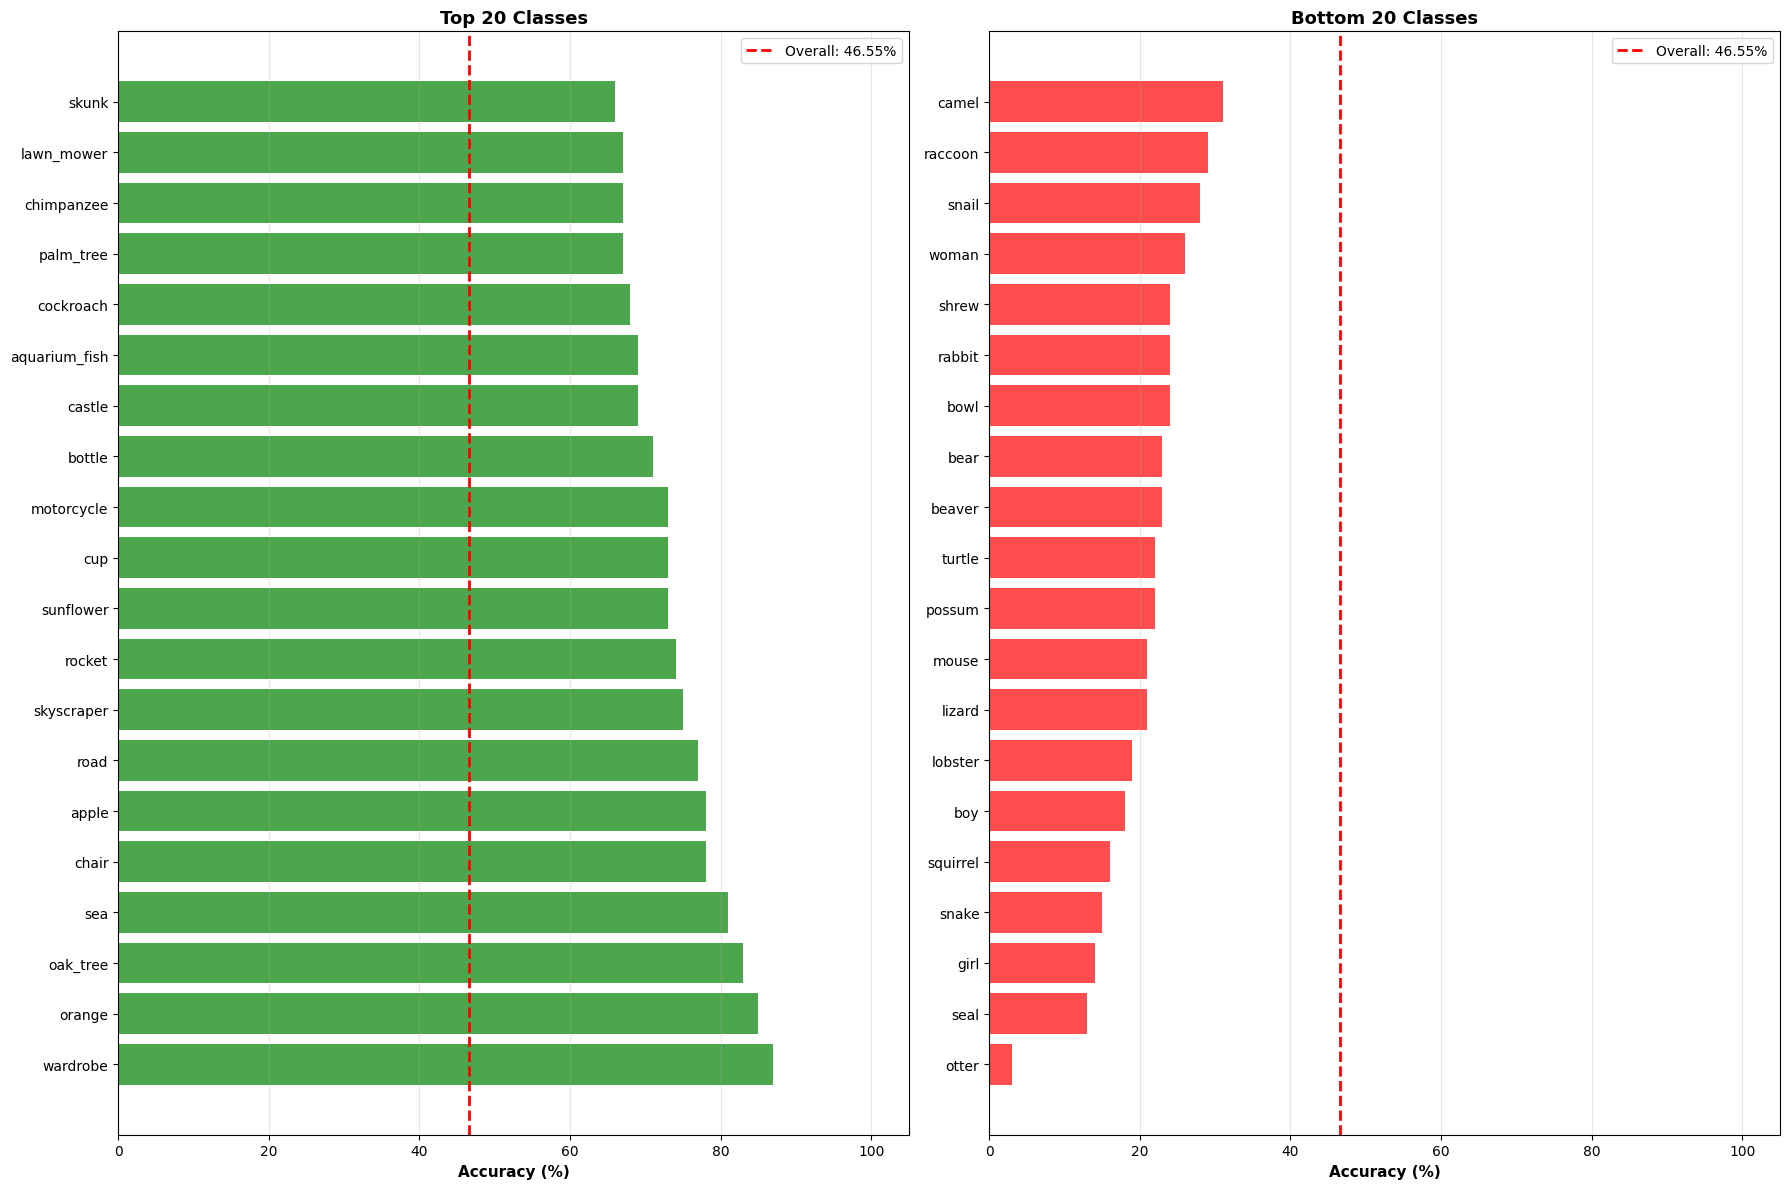


Best Performing Classes:
wardrobe            :  87.00% ( 87/100)
orange              :  85.00% ( 85/100)
oak_tree            :  83.00% ( 83/100)
sea                 :  81.00% ( 81/100)
chair               :  78.00% ( 78/100)

Worst Performing Classes:
otter               :   3.00% (  3/100)
seal                :  13.00% ( 13/100)
girl                :  14.00% ( 14/100)
snake               :  15.00% ( 15/100)
squirrel            :  16.00% ( 16/100)


In [7]:
# Calculate per-class accuracy
class_correct = []
class_total = []

for i in range(100):
    mask = all_labels == i
    class_total.append(mask.sum())
    class_correct.append((all_predictions[mask] == i).sum())

class_accuracy = [100.0 * c / t if t > 0 else 0 
                 for c, t in zip(class_correct, class_total)]

# Plot top 20 and bottom 20
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))

# Top 20 classes
top_20_idx = np.argsort(class_accuracy)[-20:][::-1]
top_20_names = [CLASS_NAMES[i] for i in top_20_idx]
top_20_acc = [class_accuracy[i] for i in top_20_idx]
colors_top = ['green' if acc > accuracy else 'orange' for acc in top_20_acc]

ax1.barh(top_20_names, top_20_acc, color=colors_top, alpha=0.7)
ax1.axvline(accuracy, color='red', linestyle='--', linewidth=2, 
           label=f'Overall: {accuracy:.2f}%')
ax1.set_xlabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax1.set_title('Top 20 Classes', fontsize=13, fontweight='bold')
ax1.set_xlim([0, 105])
ax1.legend(fontsize=10)
ax1.grid(axis='x', alpha=0.3)

# Bottom 20 classes
bottom_20_idx = np.argsort(class_accuracy)[:20]
bottom_20_names = [CLASS_NAMES[i] for i in bottom_20_idx]
bottom_20_acc = [class_accuracy[i] for i in bottom_20_idx]
colors_bottom = ['red' if acc < accuracy-10 else 'orange' for acc in bottom_20_acc]

ax2.barh(bottom_20_names, bottom_20_acc, color=colors_bottom, alpha=0.7)
ax2.axvline(accuracy, color='red', linestyle='--', linewidth=2, 
           label=f'Overall: {accuracy:.2f}%')
ax2.set_xlabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax2.set_title('Bottom 20 Classes', fontsize=13, fontweight='bold')
ax2.set_xlim([0, 105])
ax2.legend(fontsize=10)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nBest Performing Classes:")
print("=" * 70)
for i in top_20_idx[:5]:
    print(f"{CLASS_NAMES[i]:20s}: {class_accuracy[i]:6.2f}% ({class_correct[i]:3d}/{class_total[i]:3d})")

print("\nWorst Performing Classes:")
print("=" * 70)
for i in bottom_20_idx[:5]:
    print(f"{CLASS_NAMES[i]:20s}: {class_accuracy[i]:6.2f}% ({class_correct[i]:3d}/{class_total[i]:3d})")

## 7. Confidence Distribution

Analyze prediction confidence for correct vs incorrect predictions.

/tmp/ipykernel_235332/1866839290.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([correct_confidences, incorrect_confidences],


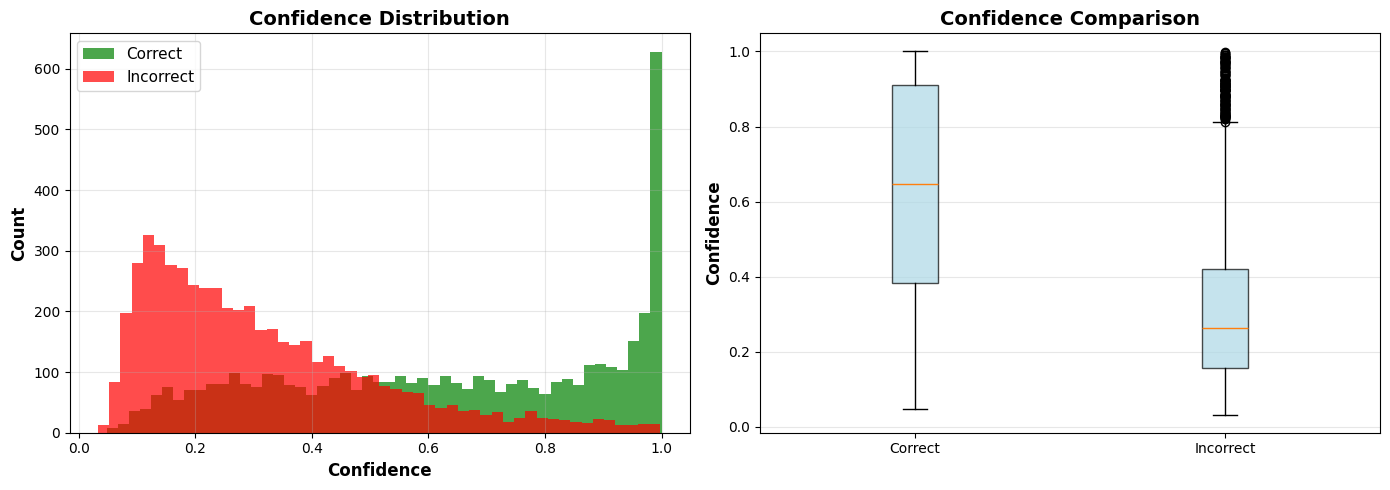


Confidence Statistics:
Correct Predictions:
  Mean confidence: 63.20%
  Median confidence: 64.75%

Incorrect Predictions:
  Mean confidence: 31.42%
  Median confidence: 26.37%


In [8]:
# Separate confidences for correct and incorrect predictions
correct_mask = all_predictions == all_labels
correct_confidences = all_confidences[correct_mask]
incorrect_confidences = all_confidences[~correct_mask]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(correct_confidences, bins=50, alpha=0.7, label='Correct', color='green')
axes[0].hist(incorrect_confidences, bins=50, alpha=0.7, label='Incorrect', color='red')
axes[0].set_xlabel('Confidence', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot([correct_confidences, incorrect_confidences],
               labels=['Correct', 'Incorrect'],
               patch_artist=True,
               boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_ylabel('Confidence', fontsize=12, fontweight='bold')
axes[1].set_title('Confidence Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nConfidence Statistics:")
print("=" * 70)
print(f"Correct Predictions:")
print(f"  Mean confidence: {correct_confidences.mean():.2%}")
print(f"  Median confidence: {np.median(correct_confidences):.2%}")
print(f"\nIncorrect Predictions:")
print(f"  Mean confidence: {incorrect_confidences.mean():.2%}")
print(f"  Median confidence: {np.median(incorrect_confidences):.2%}")

## 8. Misclassified Examples

Look at examples where the model made mistakes.

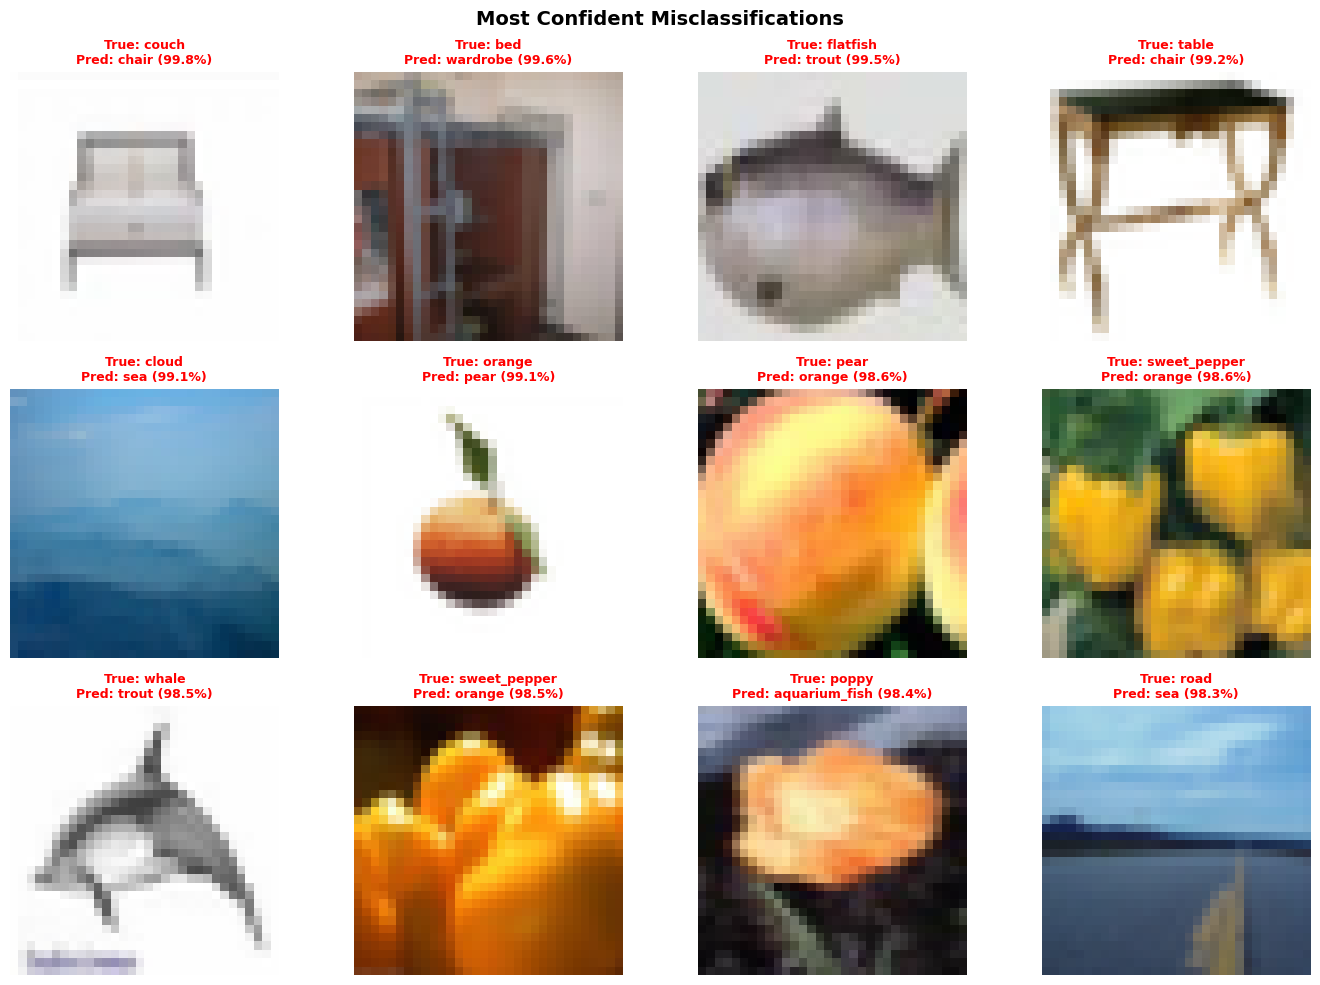


Total Misclassifications: 5345
Error Rate: 53.45%


In [9]:
# Find misclassified examples
misclassified_indices = np.where(all_predictions != all_labels)[0]

# Sort by confidence (most confident mistakes first)
sorted_indices = misclassified_indices[np.argsort(-all_confidences[misclassified_indices])]

# Show top 12 most confident mistakes
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
axes = axes.flatten()

for i, idx in enumerate(sorted_indices[:12]):
    image, true_label = test_dataset[idx]
    pred_label = all_predictions[idx]
    confidence = all_confidences[idx]
    
    axes[i].imshow(image.permute(1, 2, 0))  # CHW -> HWC
    axes[i].axis('off')
    axes[i].set_title(f'True: {CLASS_NAMES[true_label]}\n'
                     f'Pred: {CLASS_NAMES[pred_label]} ({confidence:.1%})',
                     fontsize=9, color='red', fontweight='bold')

plt.suptitle('Most Confident Misclassifications', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nTotal Misclassifications: {len(misclassified_indices)}")
print(f"Error Rate: {100.0 * len(misclassified_indices) / len(all_labels):.2f}%")

## 9. Most Confident Correct Predictions

Show examples where the model is very confident and correct.

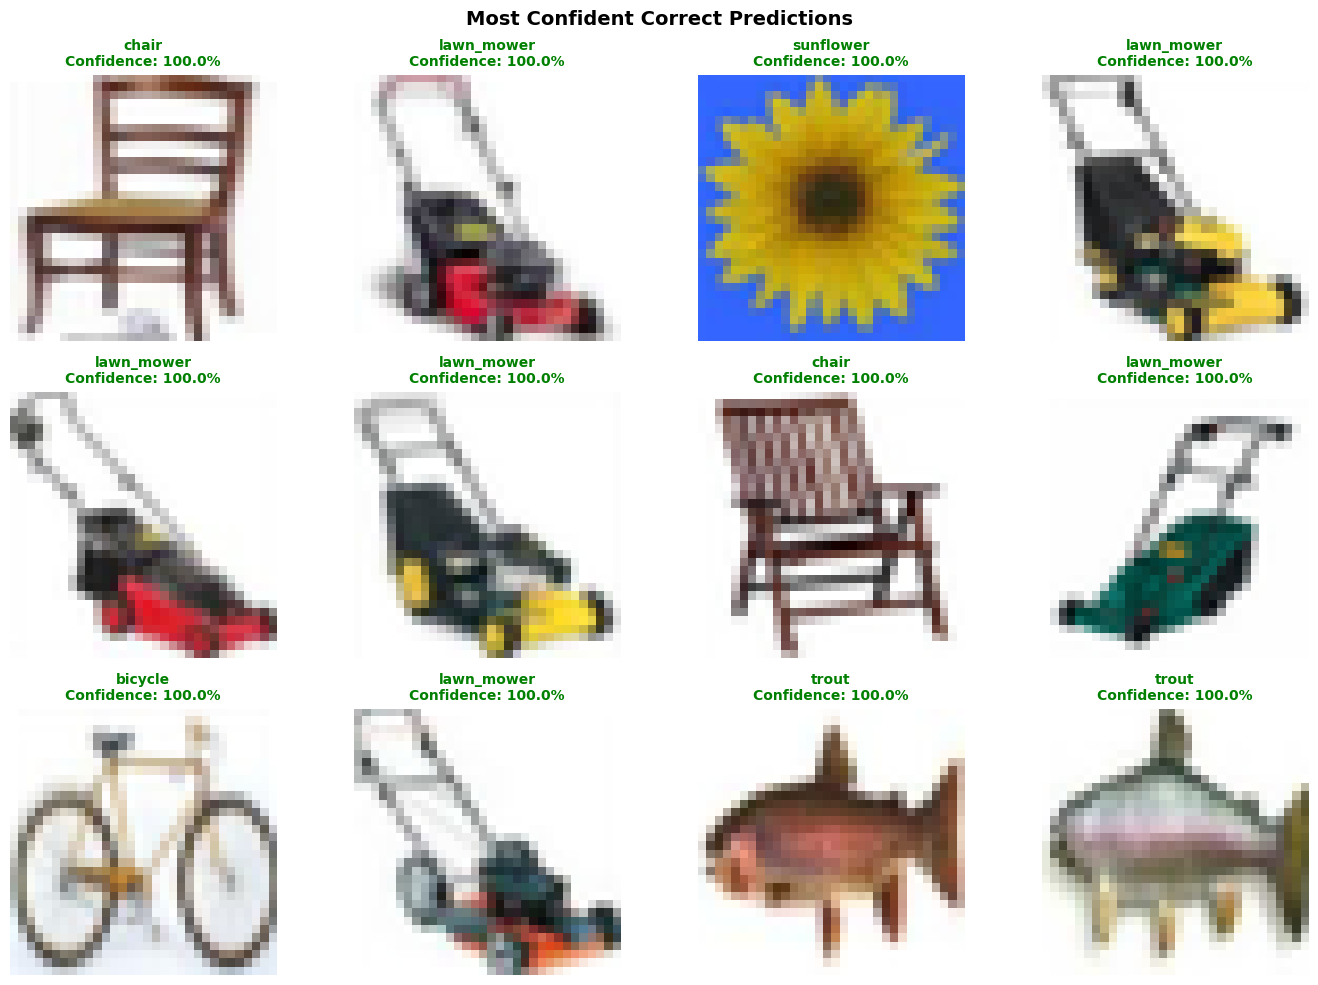

In [10]:
# Find correctly classified examples
correct_indices = np.where(all_predictions == all_labels)[0]

# Sort by confidence (most confident correct predictions)
sorted_indices = correct_indices[np.argsort(-all_confidences[correct_indices])]

# Show top 12 most confident correct predictions
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
axes = axes.flatten()

for i, idx in enumerate(sorted_indices[:12]):
    image, true_label = test_dataset[idx]
    confidence = all_confidences[idx]
    
    axes[i].imshow(image.permute(1, 2, 0))  # CHW -> HWC
    axes[i].axis('off')
    axes[i].set_title(f'{CLASS_NAMES[true_label]}\nConfidence: {confidence:.1%}',
                     fontsize=10, color='green', fontweight='bold')

plt.suptitle('Most Confident Correct Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Summary Statistics

In [11]:
print("\n" + "=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)

print(f"\nModel Performance:")
print(f"  Test Accuracy: {accuracy:.2f}%")
print(f"  Correct: {correct} / {total}")
print(f"  Errors: {total - correct}")

print(f"\nConfidence Analysis:")
print(f"  Overall mean confidence: {all_confidences.mean():.2%}")
print(f"  Correct predictions confidence: {correct_confidences.mean():.2%}")
print(f"  Incorrect predictions confidence: {incorrect_confidences.mean():.2%}")

print(f"\nBest Performing Classes:")
best_classes = np.argsort(class_accuracy)[-3:][::-1]
for i in best_classes:
    print(f"  {CLASS_NAMES[i]:15s}: {class_accuracy[i]:.2f}%")

print(f"\nWorst Performing Classes:")
worst_classes = np.argsort(class_accuracy)[:3]
for i in worst_classes:
    print(f"  {CLASS_NAMES[i]:15s}: {class_accuracy[i]:.2f}%")

if metadata:
    print(f"\nModel Training Info:")
    print(f"  Dataset: {metadata.get('dataset', 'N/A')}")
    print(f"  Training Accuracy: {metadata.get('accuracy', 'N/A')}%")
    print(f"  Epochs: {metadata.get('epochs', 'N/A')}")

print("\n" + "=" * 70)


SUMMARY STATISTICS

Model Performance:
  Test Accuracy: 46.55%
  Correct: 4655 / 10000
  Errors: 5345

Confidence Analysis:
  Overall mean confidence: 46.22%
  Correct predictions confidence: 63.20%
  Incorrect predictions confidence: 31.42%

Best Performing Classes:
  wardrobe       : 87.00%
  orange         : 85.00%
  oak_tree       : 83.00%

Worst Performing Classes:
  otter          : 3.00%
  seal           : 13.00%
  girl           : 14.00%

Model Training Info:
  Dataset: CIFAR-100
  Training Accuracy: 46.74%
  Epochs: 15



---

## 📝 Adapting to Other Datasets

To use this notebook with other datasets, modify these parameters:

### CIFAR-10
```python
MODEL_DIR = '../saved_models/cifar10/'
model = load_v28_model(MODEL_DIR, in_channels=3, num_classes=10, input_size=32)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']
```

### CIFAR-100
```python
MODEL_DIR = '../saved_models/cifar100/'
model = load_v28_model(MODEL_DIR, in_channels=3, num_classes=100, input_size=32)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
# CLASS_NAMES = [...] # 100 classes
```

### SVHN
```python
MODEL_DIR = '../saved_models/svhn/'
model = load_v28_model(MODEL_DIR, in_channels=3, num_classes=10, input_size=32)
test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
CLASS_NAMES = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
```

---

## 💡 Note on Imports

This notebook imports directly from the same directory:
```python
from model_loader import load_v28_model, load_metadata
```

If you're running Python scripts from a different directory, adjust the import:
```python
# From v28_baseline/ directory
from inference.model_loader import load_v28_model, load_metadata

# From anywhere else
import sys
sys.path.append('/path/to/v28_baseline')
from inference.model_loader import load_v28_model, load_metadata
```

---

**v28 Baseline Framework**  
**Date**: 2025-11-17  
**Status**: Production Ready